# SETUP

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the packages

In [ ]:
!pip install -U scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.manifold import TSNE
from statsmodels.sandbox.stats.multicomp import multipletests
import warnings 
warnings.filterwarnings("ignore")

# set the numpy seed
np.random.seed(1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load the functions useful for the notebook

In [ ]:
execfile('feature_clustering_func.py')

# LOAD THE DATA

Create the datasets for the feature clustering

In [ ]:
# load the data
Dataset = pd.read_csv('Dataset_EZH2.csv', index_col = "Unnamed: 0") # dataset with the non-genomic variables
Dataset2 = pd.read_csv('Dataset_Islands_Means.csv', index_col = "Unnamed: 0") # dataset with the means of each island

# create the class column
Dataset_with_class = Dataset
Dataset_with_class['class'] = ~ Dataset_with_class['time.to.disease'].isnull() 

# join in a unique dataset
Dataset_complete = Dataset2.join(Dataset_with_class[['time.to.disease', 'study', 'age.recr', 'bmi', 'sex', 'smoking', 'alcohol', 'education', 'phys.act', 'dietary.qual', 'class', 'match.id']])

# select the breast observations and create the time binned variable
DatasetB = Dataset_complete[Dataset_complete['study']=='B'].copy()
DatasetB['time.binned'] = pd.cut(DatasetB['time.to.disease'], bins = (1,3.5,7,10.5,16))

# select the cases
DatasetB = DatasetB[DatasetB['class']==True]

# datasets for the breast cases
Dataset2B=DatasetB.copy() # dataset with also the non-genomic variables
DatasetB=DatasetB.drop(['time.to.disease', 'study', 'age.recr', 'bmi', 'sex', 'smoking', 'alcohol', 'education', 'phys.act', 'dietary.qual', 'class', 'match.id', 'time.binned'], axis=1) # dataset with only the genomic variables to be used for feature clustering
# Dataset2B.to_csv('Dataset_Island_means_time.csv') # save the dataset for the standard EWAS approach

# select the controls
Dataset_controls=Dataset_complete[Dataset_complete['class']==False].copy()

# datasets for all the controls
Dataset_controls['time.binned']=pd.cut(Dataset_controls['time.to.disease'], bins=(1,3.5,7,10.5,16))
Dataset_controls2=Dataset_controls.copy() # dataset with also the non-genomic variables
Dataset_controls=Dataset_controls.drop(['time.to.disease', 'study', 'age.recr', 'bmi', 'sex', 'smoking', 'alcohol', 'education', 'phys.act', 'dietary.qual', 'class', 'match.id', 'time.binned'],axis=1) # dataset with only the genomic variables to be used for feature clustering

# select the colon and lung cases
Dataset_cases_colonlung=Dataset_complete[Dataset_complete['class']==True].copy()
Dataset_cases_colonlung=Dataset_cases_colonlung[Dataset_cases_colonlung['study']!="B"]

# datasets for the colon and lung cases
Dataset_cases_colonlung['time.binned']=pd.cut(Dataset_cases_colonlung['time.to.disease'], bins=(1,3.5,7,10.5,16))
Dataset_cases_colonlung2=Dataset_cases_colonlung.copy() # dataset with also the non-genomic variables
Dataset_cases_colonlung=Dataset_cases_colonlung.drop(['time.to.disease', 'study', 'age.recr', 'bmi', 'sex', 'smoking', 'alcohol', 'education', 'phys.act', 'dietary.qual', 'class', 'match.id', 'time.binned'],axis=1) # dataset with only the genomic variables to be used for feature clustering

# scaling based on the breast cases
scaler = StandardScaler().fit(DatasetB)

# transform each dataset
DatasetB_scaled = scaler.transform(DatasetB)
Dataset_controls_scaled = scaler.transform(Dataset_controls)
Dataset_cases_colonlung_scaled = scaler.transform(Dataset_cases_colonlung)

# APPLY FEATURE CLUSTERING

Feature clustering algorithm to transform the dataset

In [ ]:
# select data and dimensionalities for feature clustering
X=DatasetB_scaled
range_n_clusters = [128,256,512,1024]

# list of the numerosity of each cluster
counts_list=[]

for n_clusters in range_n_clusters: # for every dimensionality

  # fit feature clustering
  clusterer = cluster.FeatureAgglomeration(n_clusters=n_clusters, affinity="euclidean",  linkage="ward", pooling_func=np.mean)
  clusterer.fit(X)
  
  # extract useful quantities
  cluster_labels = clusterer.fit(X).labels_ # extract the labels
  unique, counts_loc = np.unique(cluster_labels, return_counts=True) # extract the numerosity of clusters
  counts_list.append(counts_loc)
  
  # transform the breast cases and save the dataset
  DatasetB_final=transform_clustering(DatasetB_scaled, clusterer, Dataset2B)
  # DatasetB_final.to_csv('Clustering_Breast'+str(n_clusters)+'.csv')

  # transform the controls and save the dataset
  Dataset_controls_final=transform_clustering(Dataset_controls_scaled, clusterer, Dataset_controls2)
  # Dataset_controls_final.to_csv('Clustering_Controls'+str(n_clusters)+'.csv')
    
  # transform the colon and lung cases and save the dataset
  Dataset_cases_colonlung_final=transform_clustering(Dataset_cases_colonlung_scaled, clusterer, Dataset_cases_colonlung2)
  # Dataset_cases_colonlung_final.to_csv('Clustering_Cases_colonlung'+str(n_clusters)+'.csv')

FeatureAgglomeration(n_clusters=128)

FeatureAgglomeration(n_clusters=256)

FeatureAgglomeration(n_clusters=512)

FeatureAgglomeration(n_clusters=1024)

Plot the granularity of the clusters of each dimensionality

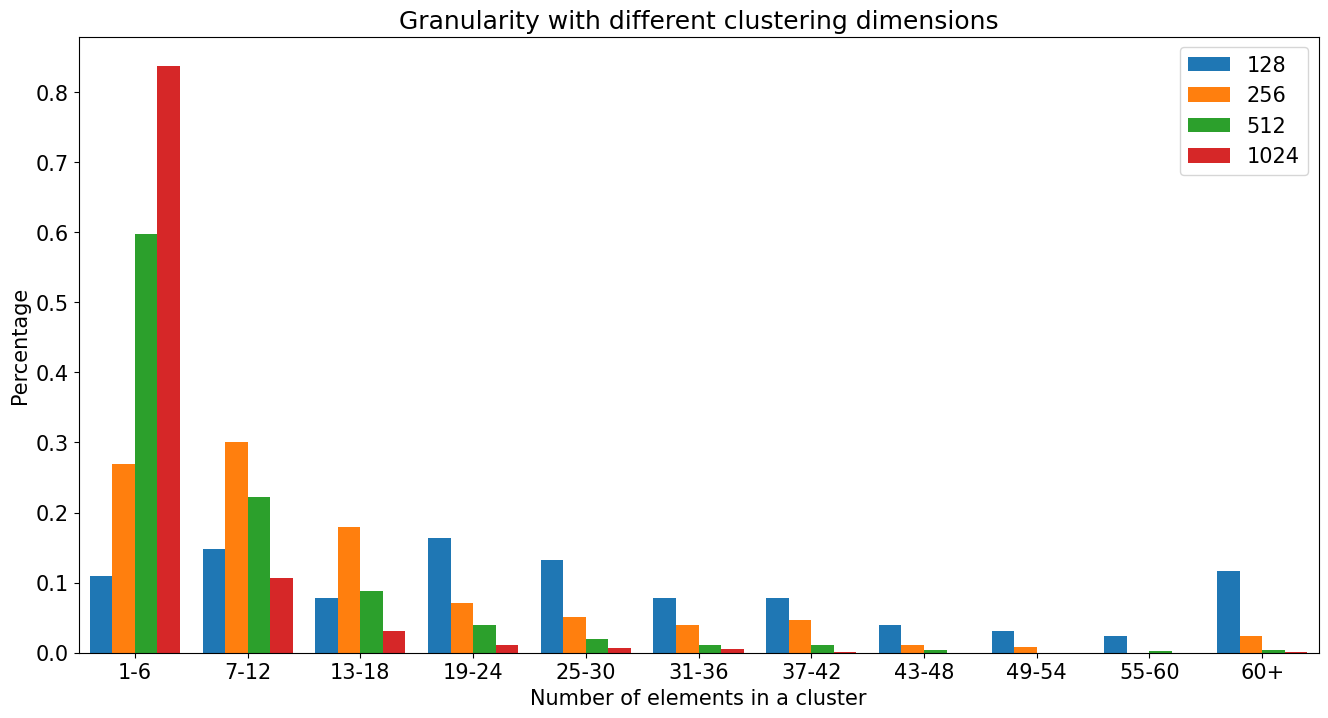

In [ ]:
labels=['128', '256', '512', '1024']
plot_granularity(counts_list, labels)

# SAVE THE RESULTS

Analyze for 128 dimensions

In [ ]:
# apply feature clustering for 128 dimensions
n_clusters=128
agglo = cluster.FeatureAgglomeration(n_clusters=n_clusters, affinity="euclidean",  linkage="ward", pooling_func=np.mean, compute_distances=True)
agglo.fit(DatasetB_scaled)
DatasetB_reduced = agglo.transform(DatasetB_scaled)
lab=agglo.labels_

FeatureAgglomeration(compute_distances=True, n_clusters=128)

## DEEP SURVIVAL MODEL WITH PRETRAINING

Plot the importance of each island for each reference (to run after finding the results of the best model)

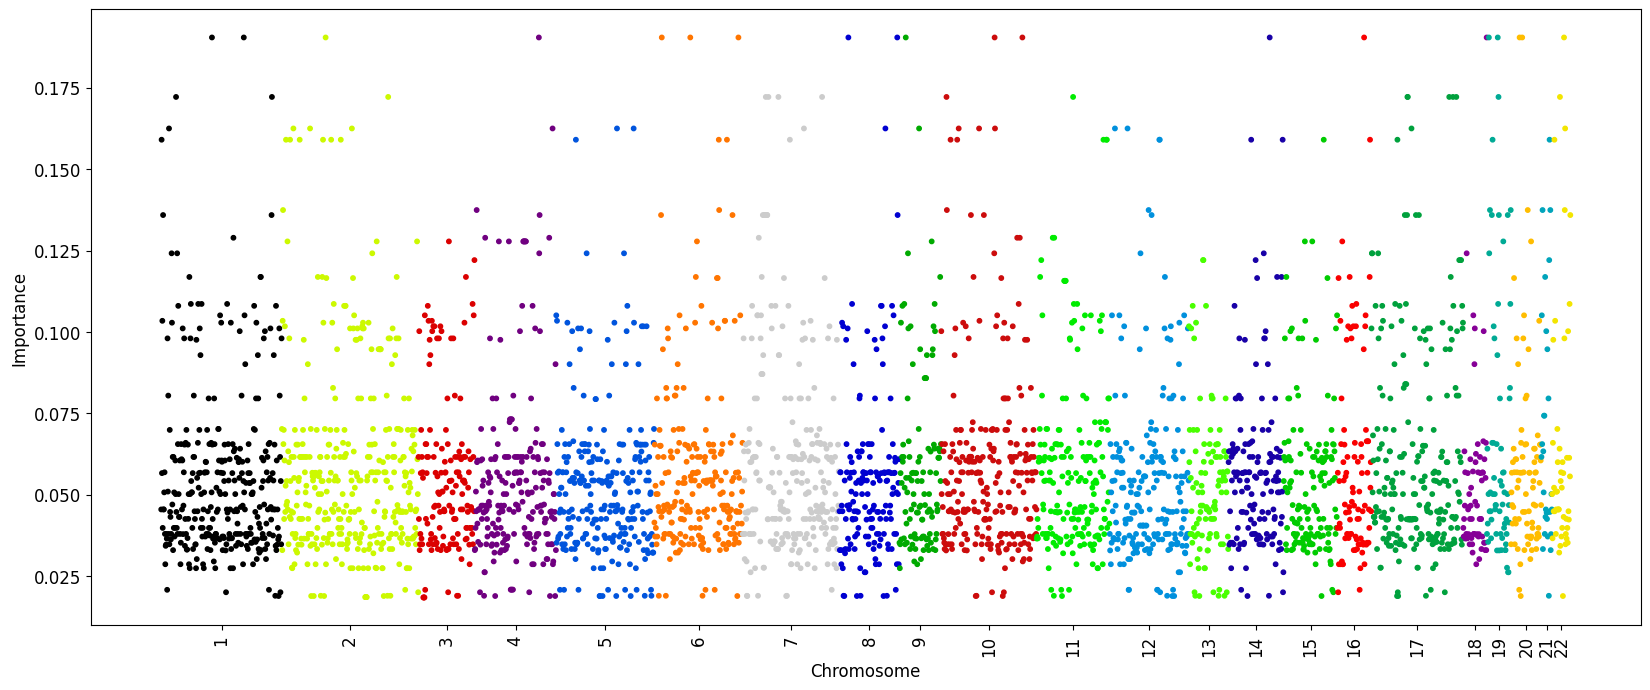

In [ ]:
path="" # for example "/content/drive/My Drive/"
name="Clustering_Breast_shapsglobal_controlsbreast_" # reference instead of "controlsbreast_" can also be: "controlsmatched_", "controlsall_female_", "casescolonlung_controlsall_female_"
# name="shapsglobal_controlsbreast_"
columns=DatasetB.columns

# construct and then save the dataset with the results of the respective reference (island-feature-importance-ranking)
df=construct_dataset_results(path, name, columns, lab, n_clusters)
# df.to_csv('shapsglobal_controlsbreast.csv')

# plot the results
plot_results(df)

## COX MODEL

Plot the -log10(p-values) (standard and Bonferroni corrected) of each island according to the standard EWAS approach

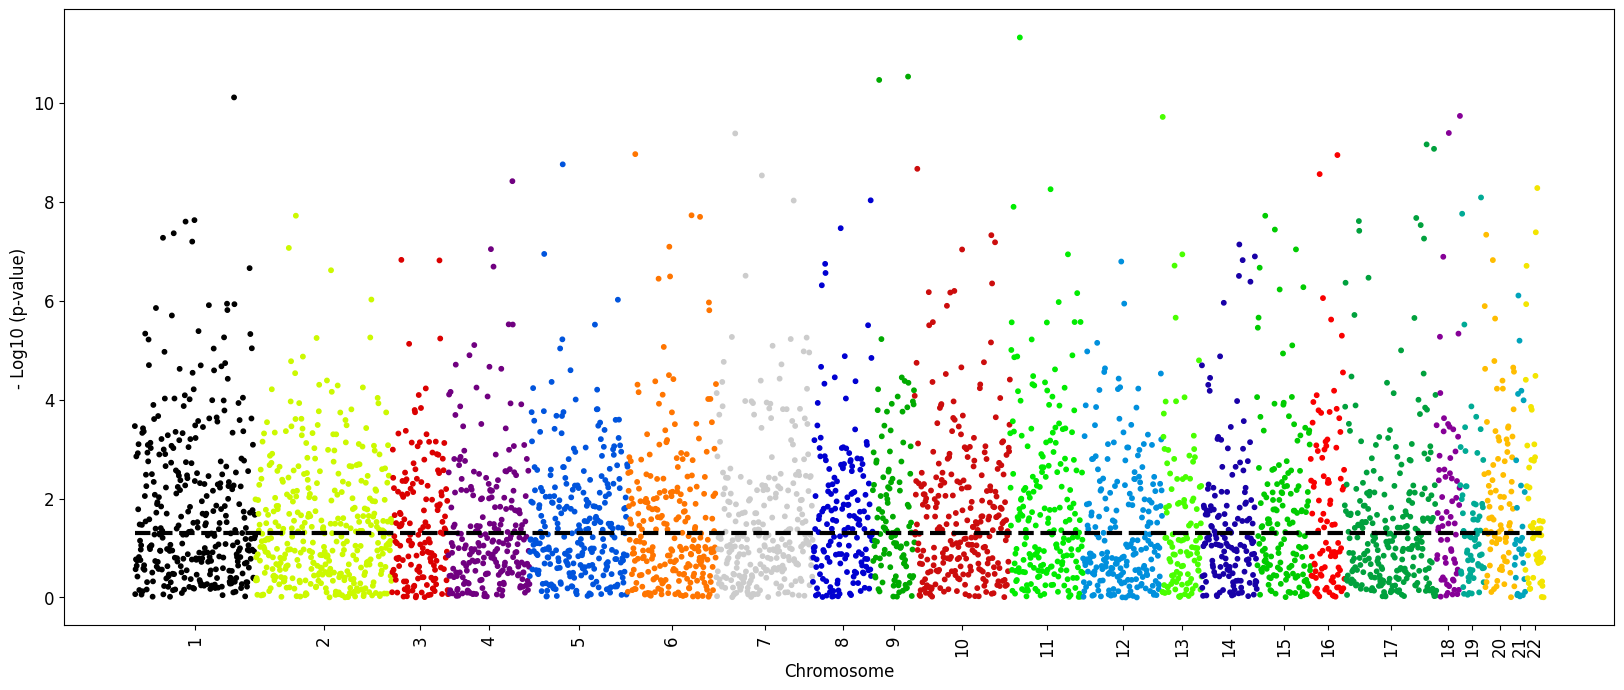

In [ ]:
path="" # for example "/content/drive/My Drive/"
name="cox_pvalues_standard_paper"
# name="pvalues_standard"
mode="standard" # instead of "standard" can be also: "bonferroni"

# plot the results
plot_results_cox(path, name, mode)

## XGBOOST MODEL

Plot the importance of each island (to run after finding the results of the best model)

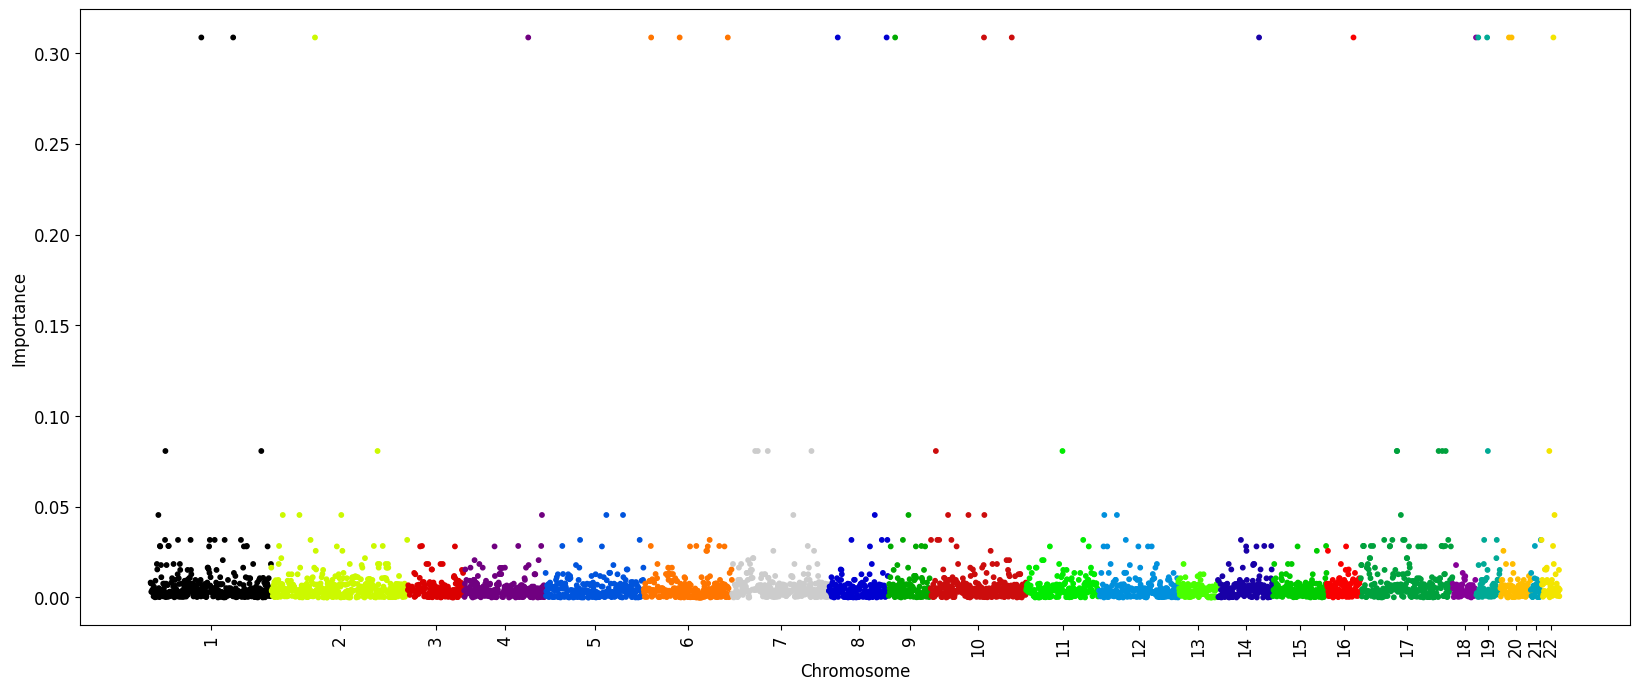

In [ ]:
path="" # for example "/content/drive/My Drive/"
name="xgboost_shap_"
columns=DatasetB.columns

# construct and then save the dataset with the results of the respective reference (island-feature-importance-ranking)
df=construct_dataset_results(path, name, columns, lab, n_clusters)
# df.to_csv('shaps_xgboost_' + str(n_clusters) + '.csv')

# plot the results
plot_results(df)

## DEEP SURVIVAL MODEL WITHOUT PRETRAINING

Plot the importance of each island for each reference (to run after finding the results of the best model)

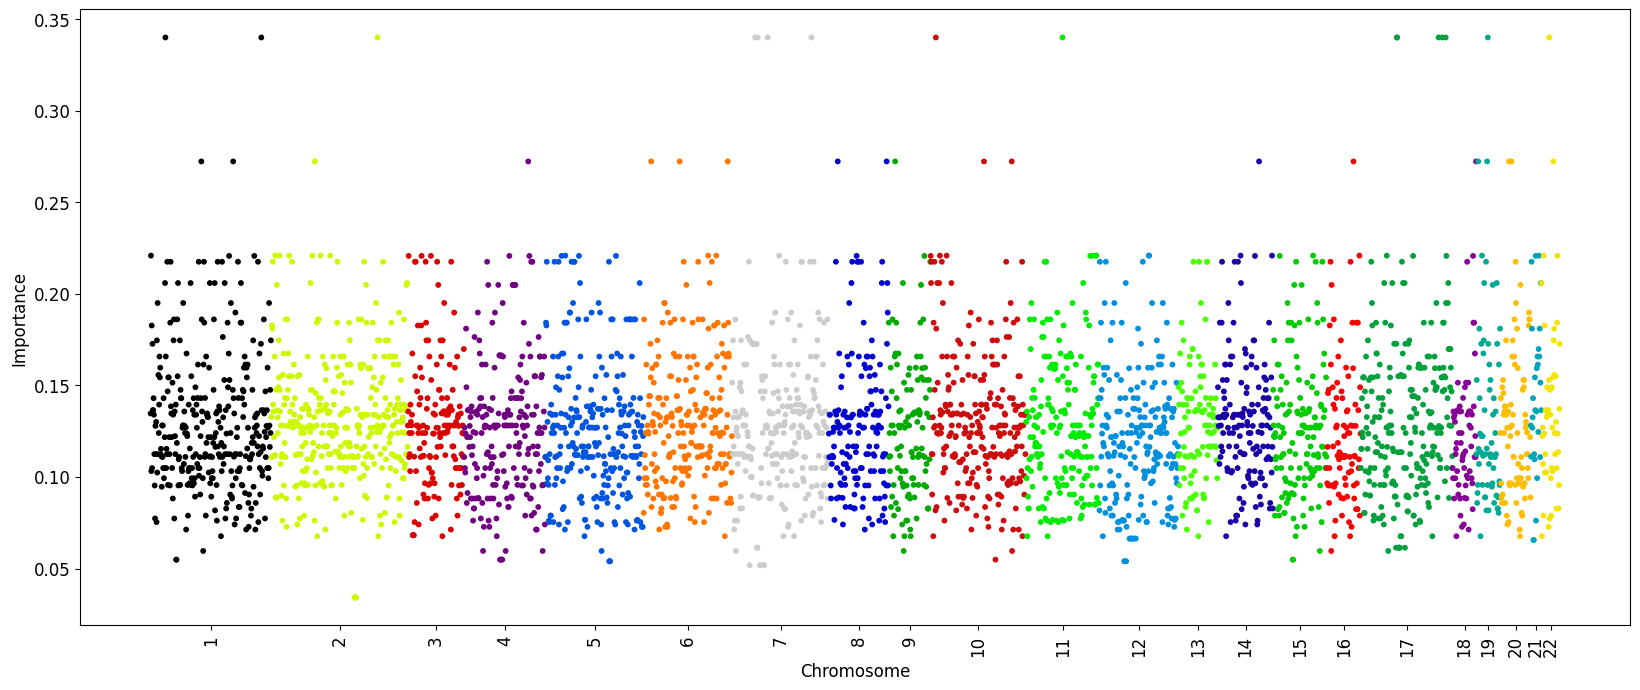

In [ ]:
path="" # for example "/content/drive/My Drive/"
name="shapsglobal_controlsbreast_no_pre_"
columns=DatasetB.columns
latent_dim = 16

# construct and then save the dataset with the results of the respective reference (island-feature-importance-ranking)
df=construct_dataset_results(path, name, columns, lab, n_clusters, latent_dim)
df.to_csv('shaps_no_pre_' + str(n_clusters) + '_' + str(latent_dim) + '.csv')

# plot the results
plot_results(df)

Save the best feature's islands

In [ ]:
# create a dataset with the islands of the best feature 120
best_features=DatasetB[DatasetB.columns[np.where(lab == 120)]].copy()
best_features['time.to.disease']=Dataset2B['time.to.disease']
best_features['time.binned4']=pd.qcut(Dataset2B['time.to.disease'], q=4)
# best_features.to_csv(os.path.join('best_features.csv'))

# print the best feature's islands
DatasetB.columns[np.where(lab == 120)]

Index(['1:90945518-90945656', '1:158090642-158091676',
       '10:102493904-102494072', '10:119294070-119294143',
       '14:87862626-87863008', '16:85096322-85097146', '18:75811758-75814395',
       '19:1704275-1706659', '19:13070446-13070515', '2:100086548-100088317',
       '20:21438169-21438255', '20:21449303-21449404', '22:37180713-37182260',
       '4:149584089-149584799', '6:1570179-1570756', '6:43530362-43531683',
       '6:166137998-166138866', '8:21701267-21701566', '8:145119282-145120028',
       '9:34618796-34619343'],
      dtype='object')